In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def main():
    # Load the dataset from the uploaded file
    df = pd.read_csv('/content/drive/MyDrive/Datasets/spotify_dataset.csv')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# CSV 파일 로드
file_path = '/content/drive/MyDrive/Datasets/spotify_dataset.csv'
df = pd.read_csv(file_path)

# 데이터셋 확인
print("데이터셋 정보:")
print(df.head())
print(df.info())

# 목표 변수 생성: 'Hit' 여부
def categorize_hit(row):
    return 1 if row <= 30 else 0  # 차트 순위가 30위 이내면 Hit(1), 아니면 Not Hit(0)

df['Hit'] = df['Highest Charting Position'].apply(categorize_hit)

# 범주형 변수 인코딩 (예: 'Genre' 등)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 독립 변수(X)와 종속 변수(y) 분리
X = df.drop('Hit', axis=1).values
y = df['Hit'].values

# 데이터 스케일링 (표준화)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 데이터 분리 (훈련, 검증, 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


데이터셋 정보:
   Highest Charting Position  Danceability  Energy  Loudness  Speechiness  \
0                          1         0.714   0.800    -4.808       0.0504   
1                          2         0.591   0.764    -5.484       0.0483   
2                          1         0.563   0.664    -5.044       0.1540   
3                          3         0.808   0.897    -3.712       0.0348   
4                          5         0.736   0.704    -7.409       0.0615   

   Acousticness  Liveness    Tempo  Duration (ms)  
0        0.1270    0.3590  134.002         211560  
1        0.0383    0.1030  169.928         141806  
2        0.3350    0.0849  166.928         178147  
3        0.0469    0.3640  126.026         231041  
4        0.0203    0.0501  149.995         212000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  ----- 

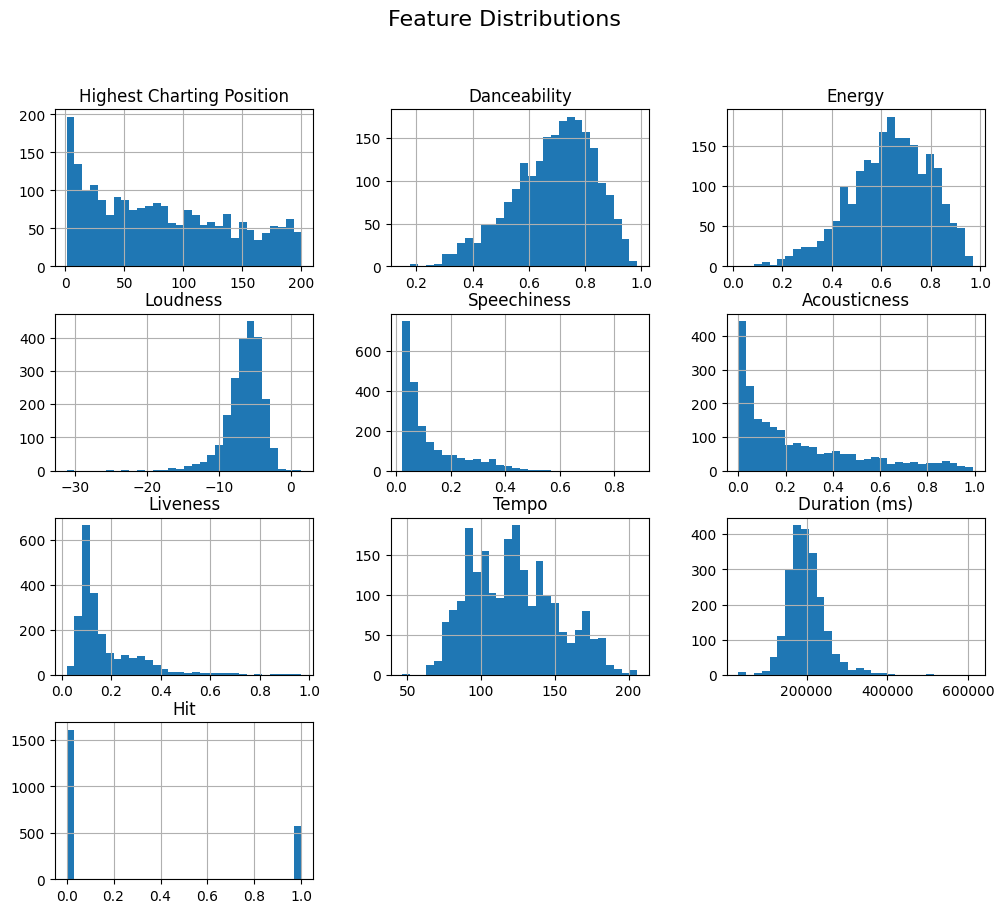

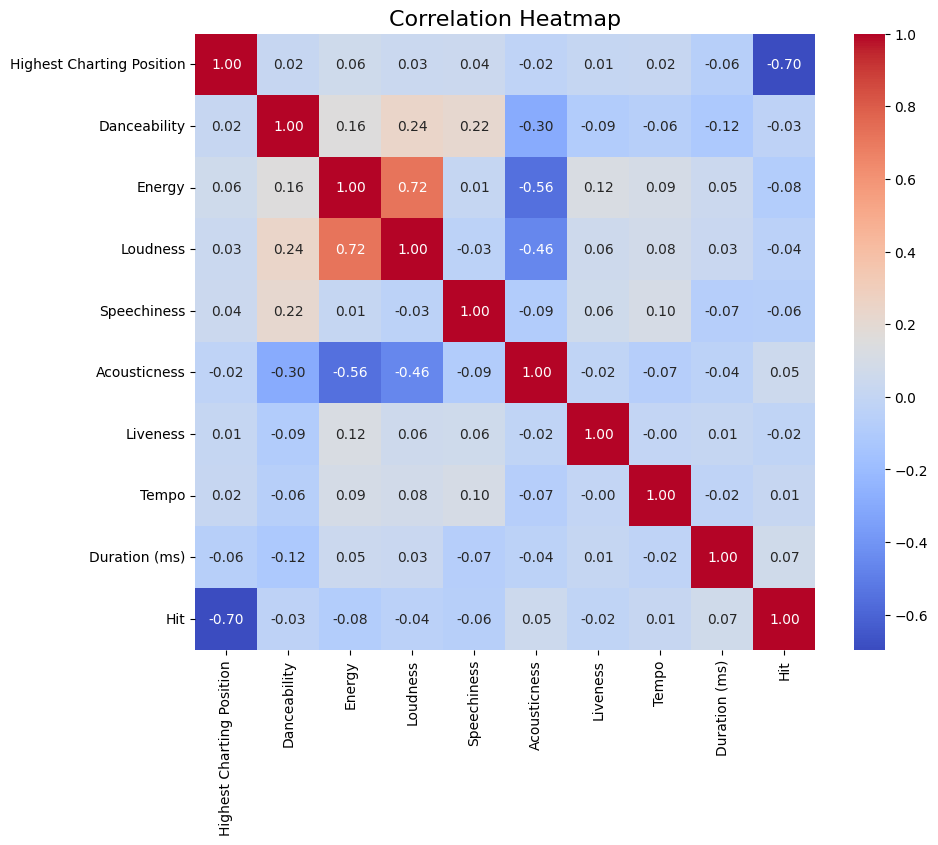

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 히스토그램
df.hist(figsize=(12, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# 상관관계 히트맵
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [ ]:
class SpotifyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SpotifyRankPredictor(nn.Module):
    def __init__(self, num_categories):
        super(SpotifyRankPredictor, self).__init__()


        self.input_layer = nn.Linear(8, 64)

        self.block1 = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        self.block2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3)
        )
        self.output_layer = nn.Linear(32, num_categories)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = nn.ReLU()(x)

        identity = x
        x = self.block1(x) + identity

        x = self.block2(x)

        x = self.output_layer(x)
        return self.softmax(x)

def augment_features(features, num_samples_needed):
    augmented_data = []
    feature_names = ['Danceability', 'Energy', 'Loudness', 'Speechiness',
                     'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)']

    # 각 특성의 표준편차를 기반으로 노이즈 범위 동적 설정
    noise_scales = {
        feat: np.std(features[:, i]) * 0.1  # 표준편차의 10%
        for i, feat in enumerate(feature_names)
    }

    for _ in range(num_samples_needed):
        base_sample = features[np.random.randint(len(features))]
        new_features = []

        for feat_idx, feat_name in enumerate(feature_names):
            feature = base_sample[feat_idx]
            noise = np.random.normal(0, noise_scales[feat_name])
            new_value = feature + noise

            if feat_name == 'Loudness':
                new_value = np.clip(new_value, -60, 0)
            elif feat_name == 'Duration (ms)':
                new_value = max(1000, new_value)
            else:
                new_value = np.clip(new_value, 0, 1)

            new_features.append(new_value)

        augmented_data.append(new_features)

    return np.array(augmented_data)

def calculate_class_weights(categories):
    class_counts = np.bincount(categories)
    weights = 1 + np.log1p(np.max(class_counts) / class_counts)
    return torch.FloatTensor(weights)

def preprocess_data_with_augmentation(df):
    X = df[['Danceability', 'Energy', 'Loudness', 'Speechiness',
            'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)']].values

    def rank_to_category(rank):
        if rank <= 30:
            return 0
        elif rank <= 50:
            return 1
        else:
            return 2

    ranks = df['Highest Charting Position'].values
    categories = np.array([rank_to_category(rank) for rank in ranks])

    # 각 카테고리별 샘플 수 계산
    category_counts = np.bincount(categories)
    print("Original category counts:", category_counts)

    # 목표 샘플 수 설정 (가장 많은 클래스의 90%로 조정)
    target_samples = int(max(category_counts) * 0.9)
    print("Target samples per category:", target_samples)

    processed_features = []
    processed_categories = []

    for category in range(3):
        category_mask = categories == category
        category_features = X[category_mask]
        current_samples = len(category_features)

        if current_samples < target_samples:
            num_samples_needed = target_samples - current_samples
            augmented = augment_features(category_features, num_samples_needed)
            processed_features.append(np.vstack([category_features, augmented]))
            processed_categories.extend([category] * target_samples)
        else:
            processed_features.append(category_features)
            processed_categories.extend([category] * current_samples)

    X_combined = np.vstack(processed_features)
    categories_combined = np.array(processed_categories)

    # 특성 스케일링
    scaler = StandardScaler()  # MinMaxScaler에서 StandardScaler로 변경
    X_scaled = scaler.fit_transform(X_combined)

    # 원-핫 인코딩
    num_categories = 3
    y_encoded = np.eye(num_categories)[categories_combined]

    print("Final category counts:", np.bincount(categories_combined))

    # 클래스 가중치 계산
    class_weights = calculate_class_weights(categories_combined)

    return X_scaled, y_encoded, num_categories, class_weights

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=150, patience=15):  # 에포크 수와 patience 증가
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)  # 가중치가 적용된 criterion을 device로 이동

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    best_val_accuracy = 0  # 최고 검증 정확도 추적

    for epoch in range(num_epochs):
        # 훈련 단계
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            # Gradient Clipping 추가
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, actual = torch.max(y_batch.data, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == actual).sum().item()

        train_loss /= len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        train_losses.append(train_loss)

        # 검증 단계
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                _, actual = torch.max(y_batch.data, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == actual).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # 모델 저장 조건을 검증 정확도 기준으로 변경
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
            }, 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered! Best validation accuracy: {best_val_accuracy:.2f}%')
                break

    return train_losses, val_losses

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Softmax를 통해 확률값으로 변환
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)  # 기본 CrossEntropy 손실
        pt = torch.exp(-ce_loss)  # 예측 확률
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # Focal Loss 계산

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def main():
    df = pd.read_csv('/content/drive/MyDrive/Datasets/spotify_dataset.csv')
    X_scaled, y_encoded, num_categories, class_weights = preprocess_data_with_augmentation(df)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded.argmax(axis=1)
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
    )

    train_dataset = SpotifyDataset(X_train, y_train)
    val_dataset = SpotifyDataset(X_val, y_val)
    test_dataset = SpotifyDataset(X_test, y_test)

    batch_size = 64  # 배치 사이즈 증가
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = SpotifyRankPredictor(num_categories)

    # Focal Loss 사용
    criterion = FocalLoss(alpha=1, gamma=2, reduction='mean')

    # 옵티마이저 설정 변경
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    # 학습률 스케줄러 추가
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                     factor=0.5, patience=5,
                                                     verbose=True)

    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=150,
        patience=15
    )

    # 최고 성능 모델 불러오기
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # 테스트 세트에서 평가
    test_loss = 0
    correct = 0
    total = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, actual = torch.max(y_batch.data, 1)
            total += y_batch.size(0)
            correct += (predicted == actual).sum().item()
            y_pred.extend(predicted.numpy())
            y_true.extend(actual.numpy())

    accuracy = 100 * correct / total
    print(f'\nTest Accuracy: {accuracy:.2f}%')

    # 혼동 행렬 및 분류 보고서 출력
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("Class weights:", class_weights)

if __name__ == "__main__":
    main()

Original category counts: [ 578  235 1377]
Target samples per category: 1239
Final category counts: [1239 1239 1377]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/150], Train Loss: 0.4271, Train Acc: 51.75%, Val Loss: 0.3867, Val Acc: 62.08%
Epoch [2/150], Train Loss: 0.3864, Train Acc: 59.53%, Val Loss: 0.3760, Val Acc: 62.34%
Epoch [3/150], Train Loss: 0.3766, Train Acc: 61.54%, Val Loss: 0.3678, Val Acc: 62.60%
Epoch [4/150], Train Loss: 0.3732, Train Acc: 62.22%, Val Loss: 0.3708, Val Acc: 62.86%
Epoch [5/150], Train Loss: 0.3759, Train Acc: 61.12%, Val Loss: 0.3739, Val Acc: 62.08%
Epoch [6/150], Train Loss: 0.3672, Train Acc: 62.65%, Val Loss: 0.3699, Val Acc: 64.16%
Epoch [7/150], Train Loss: 0.3593, Train Acc: 64.56%, Val Loss: 0.3717, Val Acc: 63.12%
Epoch [8/150], Train Loss: 0.3577, Train Acc: 63.91%, Val Loss: 0.3613, Val Acc: 65.97%
Epoch [9/150], Train Loss: 0.3589, Train Acc: 64.66%, Val Loss: 0.3630, Val Acc: 65.19%
Epoch [10/150], Train Loss: 0.3603, Train Acc: 63.42%, Val Loss: 0.3669, Val Acc: 63.90%
Epoch [11/150], Train Loss: 0.3588, Train Acc: 64.56%, Val Loss: 0.3733, Val Acc: 66.23%
Epoch [12/150], Train Loss: 0.

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler

# 데이터 로드
file_path = '/content/drive/MyDrive/Datasets/spotify_dataset.csv'
data = pd.read_csv(file_path)

# 특성 데이터 추출
features = data[['Danceability', 'Energy', 'Loudness', 'Speechiness',
                 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)']].values

# Scaler 정의 및 학습
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Scaler 저장
scaler_file = 'scaler.pkl'
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler saved as {scaler_file}")


Scaler saved as scaler.pkl


In [ ]:
# Scaler 로드
with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# 새로운 데이터에 적용
example_features = [
    0.700,  # Danceability
    0.800,  # Energy
    -5.0,   # Loudness
    0.05,   # Speechiness
    0.1,    # Acousticness
    0.35,   # Liveness
    130.0,  # Tempo
    200000  # Duration (ms)
]

scaled_features = loaded_scaler.transform([example_features])
print("Scaled Features:", scaled_features)


Scaled Features: [[ 0.0998178   1.01036179  0.53061762 -0.64351109 -0.59334681  1.20644975
   0.26335978  0.00829156]]


In [ ]:
# 저장된 경로에서 모델 로드
model_save_path = './best_model.pth'
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])


<ipython-input-21-a7d1136b654c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_save_path)


<All keys matched successfully>

In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

# 예측 함수
def predict_hit(model, input_features, scaler):

    model.eval()  # 모델을 평가 모드로 설정

    # 입력 데이터 전처리
    input_features = np.array(input_features).reshape(1, -1)  # 2D 배열로 변환
    scaled_features = scaler.transform(input_features)  # 특성 스케일링
    input_tensor = torch.tensor(scaled_features, dtype=torch.float32)  # PyTorch 텐서로 변환

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1).numpy().flatten()  # 클래스 확률 계산
        predicted_class = np.argmax(probabilities)  # 가장 높은 확률의 클래스 선택

    return predicted_class, probabilities

# 학습에 사용된 Scaler 로드
scaler_file = 'scaler.pkl'
with open(scaler_file, 'rb') as f:
    loaded_scaler = pickle.load(f)


# 학습된 모델 로드
model = SpotifyRankPredictor(num_categories=3)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# 예제 입력 데이터 (새로운 곡의 특성 값)
example_features = [
    0.700,  # Danceability
    0.800,  # Energy
    -5.0,   # Loudness
    0.05,   # Speechiness
    0.1,    # Acousticness
    0.35,   # Liveness
    130.0,  # Tempo
    200000  # Duration (ms)
]

# 예측 수행
predicted_class, probabilities = predict_hit(model, example_features, loaded_scaler)

# 결과 출력
class_labels = ['Top Hit', 'Mid Hit', 'Low Hit']
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Class Probabilities: {probabilities}")


Predicted Class: Low Hit
Class Probabilities: [0.27990437 0.23585273 0.48424292]


<ipython-input-23-b3ad81198810>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
